In [1]:
import torch
import sympy as sp
from IPython.display import display
import matplotlib.pyplot as plt
import matplotx
plt.style.use(matplotx.styles.pacoty)

In [2]:
from quant_func import STERound
torch.steRound = STERound.apply

In [3]:
# 12 feature input . 4 class labelling
class Dataset():
    def __init__(self, num_examples=100):
        """
        4-class Classification dataset
        W : R12 -> R4
        y = argmax(X@W + b)
        """

        torch.manual_seed(10)
        
        # Mostly sparse W with small scale and precision to represent them
        # this could be inferenced with fp4 if our model achieves this.
        self._W = torch.tensor([
            [-0.15, 0.0,   0.0,   0.0],
            [ 0.0, 0.15,  0.0,   0.0],
            [ 0.05, 0.0,  0.0,   0.0],
            [ 0.0, -0.1,  0.0,   0.0],
            [ 0.0, 0.0,   0.0,   0.22],
            [ 0.0, 0.0,   0.0,   0.0],
            [ 0.0, 0.0,   0.0,  0.21],
            [ 0.0, 0.0,   0.05,  0.0],
            [ 0.0, 0.0,   0.0,   0.0],
            [ 0.01, 0.0,  0.0,   0.0],
            [ 0.0, 0.0,   0.0,   0.0],
            [ 0.0, 0.0,   0.18,  0.0]
        ], dtype=torch.float32)

        self._bias = 0.1 * torch.tensor([0.2, -0.1, 0.3, -0.05], dtype=torch.float32)

        self.x = torch.randn(num_examples, 12, dtype=torch.float32)
        self.y = self.x @ self._W + self._bias
        self.y = torch.argmax(self.y, dim=-1)

    def show_answer(self, show=4):
        from IPython.display import display

        sp_W = sp.Matrix(self._W)
        sp_x = [sp.Symbol(f"x{i}") for i in range(self._W.shape[0])]
        sp_y = sp.Symbol("y")
        sp_func = sp.Function("argmax")
        sp_b = sp.Matrix(self._bias)

        sp_x = sp.Matrix(sp_x).T
        sp_b = sp.Matrix(sp_b).T

        sp_eq = sp.Eq(sp_y, sp_func(sp_x @ sp_W + sp_b), evaluate=False)

        print("True Pop Params")
        display(sp.Eq(sp.Symbol("W"), sp_W, evaluate=False))
        display(sp.Eq(sp.Symbol("b"), sp_b, evaluate=False))
        display(sp_eq)

# Example usage
data = Dataset()
data.show_answer()


True Pop Params


Eq(W, Matrix([
[-0.15,    0,    0,    0],
[    0, 0.15,    0,    0],
[ 0.05,    0,    0,    0],
[    0, -0.1,    0,    0],
[    0,    0,    0, 0.22],
[    0,    0,    0,    0],
[    0,    0,    0, 0.21],
[    0,    0, 0.05,    0],
[    0,    0,    0,    0],
[ 0.01,    0,    0,    0],
[    0,    0,    0,    0],
[    0,    0, 0.18,    0]]))

Eq(b, Matrix([[0.02, -0.01, 0.03, -0.005]]))

Eq(y, argmax(Matrix([[-0.15*x0 + 0.05*x2 + 0.01*x9 + 0.02, 0.15*x1 - 0.1*x3 - 0.01, 0.18*x11 + 0.05*x7 + 0.03, 0.22*x4 + 0.21*x6 - 0.005]])))

(array([32.,  0.,  0., 17.,  0.,  0., 22.,  0.,  0., 29.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

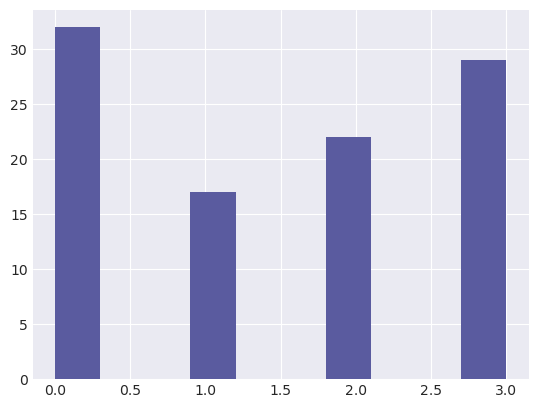

In [4]:
plt.hist(data.y)

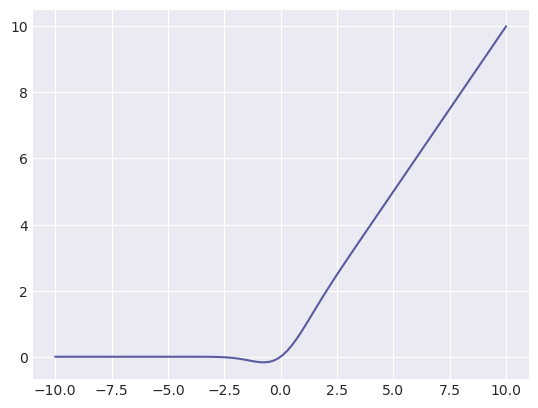

In [5]:
#simple NN 1 layer same shape
# register gelu

torch.gelu = torch.nn.GELU()
x = torch.linspace(-10,10,100)
y = torch.gelu(x)

plt.plot(x,y)

In [6]:
class SuperSimpleNN(torch.nn.Module):    
    def __init__(self):
        """
        we will diverge from the paper for now...
        we will assign an exponent and a bit depth for each of the weight and bias matrices
        usually they would be associated with 1 pair and if b reaches 0 we take out..
        that matrix from the graph.. (also optimizer states)
        """
        super().__init__()
        self.W_exp = torch.ones(12,4,dtype=torch.float32)* -8
        self.b_exp = torch.ones(1,4,dtype=torch.float32)* -8 

        # we will start with 4 bit depth for now
        self.W_depth = torch.ones_like(self.W_exp) * 4
        self.b_depth = torch.ones_like(self.b_exp) * 4
        
        self.W = torch.randn(12,4,dtype=torch.float32)
        self.b = torch.randn(1,4,dtype=torch.float32)
        
        self.W = self._quantize(self.W,self.W_exp,self.W_depth)
        self.b = self._quantize(self.b,self.b_exp,self.b_depth)

        # trainables
        self.W = torch.nn.Parameter(self.W)
        self.b = torch.nn.Parameter(self.b)
        self.W_exp = torch.nn.Parameter(self.W_exp)
        self.b_exp = torch.nn.Parameter(self.b_exp)
        self.W_depth = torch.nn.Parameter(self.W_depth)
        self.b_depth = torch.nn.Parameter(self.b_depth)


    @staticmethod
    def _quantize(x,e,b):
        b = torch.relu(b)
        upscale = x/torch.exp2(e)
        half = torch.exp2(b-1)
        clipped = torch.clip(upscale,-1*half,half-1)
        rounded = torch.steRound(clipped)
        return torch.exp2(e) * rounded

    def forward(self,x):
        # quantize every forward pass.. make depth >=0
        W_depth = torch.relu(self.W_depth)
        b_depth = torch.relu(self.b_depth)
        
        W_q = self._quantize(self.W,self.W_exp,W_depth)
        b_q = self._quantize(self.b,self.b_exp,b_depth)
    
        out = torch.gelu(x@W_q + b_q)
        return out

simple_model = SuperSimpleNN()

In [7]:
print("At init")
with torch.no_grad():
    for p in simple_model.named_parameters():
        # print(p)
        display(sp.Eq(sp.Symbol(f"{p[0]}_init"), sp.Matrix(p[1]),evaluate=False))

At init


Eq(W_init, Matrix([
[-0.00390625, 0.0273438,  -0.03125,  -0.03125],
[   -0.03125, 0.0273438,  -0.03125,  -0.03125],
[  0.0273438, 0.0273438,  -0.03125,  -0.03125],
[  0.0273438,  -0.03125, 0.0273438,  -0.03125],
[  0.0273438,  -0.03125, 0.0273438,  -0.03125],
[   -0.03125,  -0.03125, 0.0273438, 0.0273438],
[   -0.03125,  -0.03125, 0.0273438, 0.0273438],
[   -0.03125,  -0.03125,  -0.03125, 0.0273438],
[   -0.03125,  -0.03125, 0.0273438, 0.0273438],
[  0.0273438, 0.0273438,  -0.03125, 0.0273438],
[  0.0273438,  -0.03125,  -0.03125, 0.0273438],
[   -0.03125, 0.0273438,  -0.03125,  -0.03125]]))

Eq(b_init, Matrix([[-0.03125, 0.0273438, -0.03125, 0.0273438]]))

Eq(W_exp_init, Matrix([
[-8.0, -8.0, -8.0, -8.0],
[-8.0, -8.0, -8.0, -8.0],
[-8.0, -8.0, -8.0, -8.0],
[-8.0, -8.0, -8.0, -8.0],
[-8.0, -8.0, -8.0, -8.0],
[-8.0, -8.0, -8.0, -8.0],
[-8.0, -8.0, -8.0, -8.0],
[-8.0, -8.0, -8.0, -8.0],
[-8.0, -8.0, -8.0, -8.0],
[-8.0, -8.0, -8.0, -8.0],
[-8.0, -8.0, -8.0, -8.0],
[-8.0, -8.0, -8.0, -8.0]]))

Eq(b_exp_init, Matrix([[-8.0, -8.0, -8.0, -8.0]]))

Eq(W_depth_init, Matrix([
[4.0, 4.0, 4.0, 4.0],
[4.0, 4.0, 4.0, 4.0],
[4.0, 4.0, 4.0, 4.0],
[4.0, 4.0, 4.0, 4.0],
[4.0, 4.0, 4.0, 4.0],
[4.0, 4.0, 4.0, 4.0],
[4.0, 4.0, 4.0, 4.0],
[4.0, 4.0, 4.0, 4.0],
[4.0, 4.0, 4.0, 4.0],
[4.0, 4.0, 4.0, 4.0],
[4.0, 4.0, 4.0, 4.0],
[4.0, 4.0, 4.0, 4.0]]))

Eq(b_depth_init, Matrix([[4.0, 4.0, 4.0, 4.0]]))

In [8]:
x_examples = data.x.to("cuda")
y_examples = data.y.to("cuda")
torch.set_float32_matmul_precision("high")

@torch.compile
def train(epochs:int = 100_000):
    model = SuperSimpleNN()
    model.to("cuda")

    from tqdm import tqdm
    pbar = tqdm(range(epochs))
    optim = torch.optim.AdamW(model.parameters(),weight_decay=1e-3)

    for epoch in pbar:
        out = model(x_examples)
        bit_decay = torch.norm(torch.cat([
            p.flatten() for name, p in model.named_parameters()
            if "depth" in name or "exp" in name
            ]))

        loss = torch.nn.functional.cross_entropy(input = out, target = y_examples) + (1/20)* (bit_decay)
    
        if epoch % 10_000 == 0:
            pbar.set_postfix(loss=loss.item())
    
        optim.zero_grad()
        loss.backward()
        optim.step()
    return model


model = train()

100%|███████████████████| 100000/100000 [01:18<00:00, 1277.77it/s, loss=0.539]


In [9]:
with torch.no_grad():
    # quantize one last time for inference
    Wdepth = torch.relu(model.W_depth)
    bdepth = torch.relu(model.b_depth)

    Wexp = model.W_exp
    bexp = model.b_exp

    W = model.W
    b = model.b
    W = model._quantize(W,Wexp,Wdepth)
    b = model._quantize(b,bexp,bdepth)

    response = torch.argmax((x_examples@W+b),dim=-1)
    print("Score:",torch.sum(response==y_examples))
    

    sp_Wresult = sp.Matrix(W.to("cpu"))
    sp_Bresult = sp.Matrix(b.to("cpu"))
    
    display(sp.Eq(sp.Symbol("W_result"), sp_Wresult,evaluate=False))
    display(sp.Eq(sp.Symbol("B_result"), sp_Bresult,evaluate=False))

    print("==========================")


    sp_Wexpresult = sp.Matrix(model.W_exp.to("cpu"))
    sp_Wdepthresult = sp.Matrix(model.W_depth.to("cpu"))

    display(sp.Eq(sp.Symbol("W_depth_result"), sp_Wdepthresult,evaluate=False))
    display(sp.Eq(sp.Symbol("W_exp_result"), sp_Wexpresult,evaluate=False))
    

    sp_bexpresult = sp.Matrix(model.b_exp.to("cpu"))
    sp_bdepthresult = sp.Matrix(model.b_depth.to("cpu"))

    display(sp.Eq(sp.Symbol("b_depth_result"), sp_bdepthresult,evaluate=False))
    display(sp.Eq(sp.Symbol("b_exp_result"), sp_bexpresult,evaluate=False))
        

Score: tensor(97, device='cuda:0')


Eq(W_result, Matrix([
[ -4.7128,  1.02147,        0,        0],
[-1.61938,  3.28405,        0,        0],
[ 3.73113,        0,        0,        0],
[       0, -2.07219,        0,        0],
[ -1.7296,  -1.5404,        0,  7.94661],
[       0,        0,        0, -1.40395],
[       0,        0,        0,  8.21149],
[       0,        0,  3.47238,        0],
[ 1.01997,        0,        0,        0],
[       0,        0, 0.955973,        0],
[       0,        0,        0,        0],
[-2.75589,        0,  7.22146,        0]]))

Eq(B_result, Matrix([[0, 0, 0, 0]]))

Eq(W_depth_result, Matrix([
[     1.58517,     1.58538,    0.0989309,     0.118591],
[    0.487198,     2.80734, -4.60774e-16,  -1.55151e-7],
[     2.32198,  -7.4227e-7, -9.09286e-10,  9.20653e-43],
[ -4.82098e-9,     1.22048,    0.0384498, -0.000120394],
[    0.597799,    0.415882,     0.437117,      2.80863],
[ -0.00707417, -0.00469884,    0.0689907,     0.302221],
[-2.50743e-12,  -0.0120855, -7.20251e-19,      2.80785],
[      0.8946,  -0.0167259,      2.32222, -0.000260237],
[     1.58536,    0.257059, -3.62663e-14,  9.20653e-43],
[     1.58411,  9.1785e-43,      1.58537, -0.000278985],
[    0.362619, 9.05239e-43,   8.7441e-43, -8.80986e-12],
[     1.58534, -3.09325e-7,      2.80748,  -0.00129921]]))

Eq(W_exp_result, Matrix([
[    1.23658,    0.0306508,  9.19252e-43,  9.1785e-43],
[   0.695438,     0.715477,  9.19252e-43,  9.1785e-43],
[   0.899612,  9.09443e-43,  9.15048e-43, 9.09443e-43],
[9.10844e-43,      1.05116, -8.66002e-43, 9.19252e-43],
[   0.790439,     0.623305,  9.13647e-43,     1.40538],
[9.20653e-43,  9.13647e-43,  9.10844e-43,    0.489488],
[ 9.0664e-43,  9.10844e-43,  9.15048e-43,     1.45268],
[1.09021e-42,  9.15048e-43,     0.795923, 9.12245e-43],
[  0.0285311,  9.10844e-43,  9.10844e-43, 9.05239e-43],
[ -0.0177652,  9.09443e-43,   -0.0649584, 9.19252e-43],
[9.15048e-43, -9.01035e-43, -8.64601e-43,  9.1785e-43],
[   0.462517,  9.19252e-43,      1.26733, 9.15048e-43]]))

Eq(b_depth_result, Matrix([[0.218495, 1.58445, 0.53115, 0.256899]]))

Eq(b_exp_result, Matrix([[8.98232e-43, -0.185507, -8.56193e-43, 8.58996e-43]]))

In [10]:
# anytime we have exp too low then we can probably get a weight 0
# but it is guarenteed to have 0 weight if depth <=0 . 